In [1]:
# our libraries that we need; currently hidden
# ! pip install torch pandas numpy matplotlib

In [2]:
# all of our import statements to have them all
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

# Creating a Collaborative Filtering Recommendation System Using The Movie Lens Dataset

Today we will learn about latent factors, embeddings, collaborative filtering, and recommendation systems using the Movie Lens 100k dataset (find more details at this [link](https://grouplens.org/datasets/movielens/)).

## Exploration

In [3]:
import pandas as pd

ratings = pd.read_csv("./movie-lens-dataset/ratings.csv")
movies = pd.read_csv("./movie-lens-dataset/movies.csv")

collab = pd.merge(ratings, movies, on = "movieId").drop(columns = ["genres"])
collab.head()

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,1,3,4.0,964981247,Grumpier Old Men (1995)
2,1,6,4.0,964982224,Heat (1995)
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995)
4,1,50,5.0,964982931,"Usual Suspects, The (1995)"


In [4]:
collab.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [5]:
grouped_by_user_ID = collab.groupby("userId").size()
grouped_by_user_ID

userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Length: 610, dtype: int64

In [6]:
grouped_by_movie_ID = collab.groupby("movieId").count() 
len(grouped_by_movie_ID)

9724

The distribution of ratings for the movies in our dataset


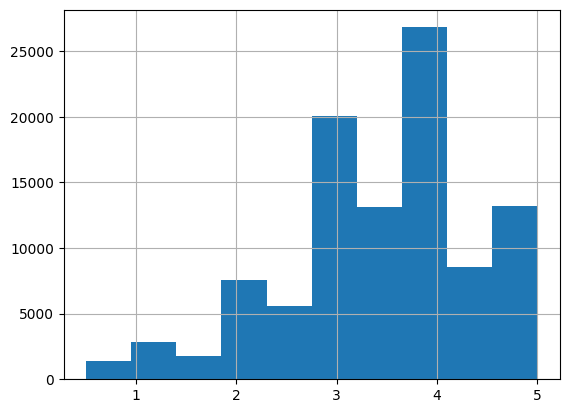

In [7]:
collab['rating'].hist()
print("The distribution of ratings for the movies in our dataset")

In [8]:
collab.pivot(index = "userId", columns = "movieId", values = "rating")

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The above pivot table shows the rating that each user assigned to each movie in the dataset. Although we see a lots of ```NaN```, this is probably a better visualization of what is happening in our data and will provide a better way of thinking about our data when creating our collaborative filter.

Our objective is to create a model that will be able to fill in those blanks. 

### Preparing our Data for Training and Testing

In [9]:
import torch
from torch.utils.data import DataLoader, random_split
from torch import tensor

input_features = ["userId", "movieId"]
target_feature = "rating"

train_xs_df = collab[input_features]
train_y_df = collab[target_feature]

train_xs_tns, train_y_tns = tensor(train_xs_df.values, dtype=torch.int32), tensor(train_y_df.values, dtype=torch.float32)

train_size = int(len(train_xs_tns) * 0.8)
valid_size = len(train_xs_tns) - train_size

train = list(zip(train_xs_tns, train_y_tns))
train_s, valid_s = random_split(train, [train_size, valid_size])

train_dl, valid_dl = DataLoader(train_s, batch_size = 16, shuffle = True), DataLoader(valid_s, batch_size = 16, shuffle = True)

## Building the Collaborative Filtering Model

### Latent Factors

One common way to approach this problem is the following. Let's say that we have a user with the following preference vector: 

$$ \vec{p} = \langle 0.2, 0.9, 0.3 \rangle $$

With $p_1$ being his preference for a movie that is action-packed, $p_2$ being his preference for movie that is under 1h30 long, and $p_3$ being his preference for old movies. 

If we have a movie that has the following criteria for his preferences: 

$$ \vec{m} = \langle 0.3, 0.7, 0.2 \rangle$$ 

We can define the user's preference to this movie by taking the dot product of the user's preference vector $\vec{p}$ and the movie's vector $\vec{m}$. 

We can use that dot product as our prediction. Thus: 

$$ \text{prediction} = \vec{p} \cdot \vec{m} $$

One very important nuance. We do not know these vectors for each user and each movie. However, using stochastic gradient descent, we can start with random weights and find the weights that provide the right prediction. 


### Embeddings

An embedding is a table that allows us to look up the latent factors for each item. These are very important in creating our model as we cannot do the simple lookup as we can do in the pivot table we've built in the previous cells.

In the next cell, we are creating a an embedding for 5 items and 2 latent factors per item.

In [10]:
def create_embedding(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

create_embedding([5,2]) 

Parameter containing:
tensor([[ 0.0181,  0.0076],
        [-0.0004,  0.0099],
        [-0.0128,  0.0038],
        [ 0.0041,  0.0052],
        [ 0.0147,  0.0043]], requires_grad=True)

### Defining Our Model



In [11]:
def interpret(prediction):
    """ A function to interpret the predictions of our model -- rounds a float to the closest 0.5"""
    pred = round(prediction, 1)
    digit = int(pred)
    decimal = round(pred-digit,1)
    if decimal > 0.25 and decimal < 0.75: 
        return digit + 0.5
    elif decimal < 0.25: 
        return float(digit)
    else: 
        return digit + 1

Our ranged sigmoid will help us make sure that our model's outputs are ranged between 0 and 5. This will help improve our model's accuracy.

In [12]:
import torch.nn.functional as F

def ranged_sigmoid(x, lower_bound, upper_bound):
  """Creates a ranged sigmoid function given a certain lower bound and upper bound"""
  sigmoid_output = F.sigmoid(x)
  scaled_output = sigmoid_output  * (upper_bound - lower_bound) + lower_bound
  return scaled_output

We have defined a basic Dot Product model (called *Probabilistic Matrix Factorization (PMF)*).

We have added bias vectors (a scalar) for each user and mvoie that we can add to our dot product to make sure to account to the fact that certain users will always rate every movie higher/lower consistently and certain movies are rated higher/lower by everyone.

In [13]:
import torch.nn as nn

class DotProduct(nn.Module):
    def __init__(self, n_users, n_movies,n_factors, y_range = (0, 5.5)):
        super().__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.user_bias = nn.Embedding(n_users, 1)
        self.movie_factors = nn.Embedding(n_movies, n_factors)
        self.movie_bias = nn.Embedding(n_movies, 1)
        self.y_range = (0, 5.5)

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        product = (users*movies).sum(dim = 1, keepdim = True)
        product += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return ranged_sigmoid(product, *self.y_range)

In [14]:
n_users = 611
n_movies = 193610
n_factors = 5

dot_product_model = DotProduct(n_users, n_movies, n_factors)

### Training Loop 

We have our standard training loop using Stochastic Gradient Descent (SGD). 

In [15]:
import torch
import numpy as np

loss_f = F.mse_loss 
SGD = torch.optim.SGD(params = dot_product_model.parameters(), lr = 0.1, weight_decay = 0.05)

def train_model(model, loss_f, optimizer): 
    def train_epoch():
        losses = []
        for xb, yb in train_dl:
            preds = model.forward(xb)
            loss = loss_f(preds, yb)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        return np.mean(np.array(losses))

    def validate_epoch():
        accuracies = []
        losses = []
        for xb, yb in valid_dl:
            preds = model.forward(xb)
            loss = loss_f(preds, yb)
            losses.append(loss.item())
            batch_accuracy = (preds.detach().apply_(interpret) == yb).float().mean().item()
            accuracies.append(batch_accuracy)
        return np.mean(np.array(accuracies)), np.mean(np.array(losses))

    for ep in range(10):
        mean_loss = train_epoch()
        valid_accuracy, valid_loss = validate_epoch()
        print(f"Epoch #{ep+1} | Train Mean Loss: {round(mean_loss, 3)} | Valid Mean Loss: {round(valid_loss, 3)} | Valid Mean Epoch Accuracy: {round(valid_accuracy, 3)} ")
    
    print("Training complete :)")
    return model

train_model(dot_product_model, loss_f, SGD)

/var/folders/9_/kcr9skyn5bx1npgv347g5ngm0000gn/T/ipykernel_82818/999512264.py:12: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_f(preds, yb)
/var/folders/9_/kcr9skyn5bx1npgv347g5ngm0000gn/T/ipykernel_82818/999512264.py:12: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_f(preds, yb)
/var/folders/9_/kcr9skyn5bx1npgv347g5ngm0000gn/T/ipykernel_82818/999512264.py:24: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_f(preds, yb)
/var/folders/9_/kcr9skyn5bx1npg

Epoch #1 | Train Mean Loss: 1.495 | Valid Mean Loss: 1.401 | Valid Mean Epoch Accuracy: 0.2 
Epoch #2 | Train Mean Loss: 1.401 | Valid Mean Loss: 1.396 | Valid Mean Epoch Accuracy: 0.2 
Epoch #3 | Train Mean Loss: 1.401 | Valid Mean Loss: 1.406 | Valid Mean Epoch Accuracy: 0.202 
Epoch #4 | Train Mean Loss: 1.401 | Valid Mean Loss: 1.406 | Valid Mean Epoch Accuracy: 0.201 
Epoch #5 | Train Mean Loss: 1.402 | Valid Mean Loss: 1.4 | Valid Mean Epoch Accuracy: 0.199 
Epoch #6 | Train Mean Loss: 1.402 | Valid Mean Loss: 1.403 | Valid Mean Epoch Accuracy: 0.201 
Epoch #7 | Train Mean Loss: 1.401 | Valid Mean Loss: 1.398 | Valid Mean Epoch Accuracy: 0.199 
Epoch #8 | Train Mean Loss: 1.402 | Valid Mean Loss: 1.402 | Valid Mean Epoch Accuracy: 0.201 
Epoch #9 | Train Mean Loss: 1.401 | Valid Mean Loss: 1.408 | Valid Mean Epoch Accuracy: 0.201 
Epoch #10 | Train Mean Loss: 1.402 | Valid Mean Loss: 1.407 | Valid Mean Epoch Accuracy: 0.201 
Training complete :)


DotProduct(
  (user_factors): Embedding(611, 5)
  (user_bias): Embedding(611, 1)
  (movie_factors): Embedding(193610, 5)
  (movie_bias): Embedding(193610, 1)
)

### Weight Decay

Weight decay (also known as *L2 Regularization*) is a regularization technique that allows us to avoid overfitting in our model.

The way that we do this is the following. We first set a weight decay factor, which we will call `wd`. We will then multiply our weight decay factor by the sum of the squares of our parameters. Then we will add this product to our loss function. 

In PyTorch,

```python
    wd_loss = loss + wd * (parameters**2).sum()
```

This can be very computationally ineffecient as we need to calculate a sum of our parameters. We can use this analogous method when calculating our gradients.

```python
    parameters.grad += wd*2*parameters
```

The intuition behind weight decay is that we are hindering the training process of our model. By increasing the loss that we calculate, we are making our model calculate lower gradients. This will help our model generalize more effectively, thus preventing overfitting.

We are able to define weight decay factor in our SGD optimizer. 

### Neural Network Approach

Instead of using the dotproduct of our embeddings, we will use the a neural network. As inputs, our network will take a concatination of our embedding vectors 

**Symbolically**

Let $e_1 = \langle e_{1.1}, e_{1.2}, e_{1.3} \rangle$ and $e_2 = \langle e_{2.1}, e_{2.2}, e_{2.3} \rangle$. Concatinating our two vectors amount to doing the following operation: 

$$ \text{cat}(e_1, e_2) = \langle e_{1.1}, e_{1.2}, e_{1.3}, e_{2.1}, e_{2.2}, e_{2.3} \rangle $$

*Side note*

I need to use the math to visualize these torch operations better. The operations are still a little abstract for me. 

In [16]:
class CollabNN(nn.Module):
    def __init__(self, n_users, n_user_factors, n_movies, n_movie_factors, y_range = (0,5.5), n_act = 100):
        super().__init__()
        self.user_factors = nn.Embedding(n_users, n_user_factors)
        self.movie_factors = nn.Embedding(n_movies, n_movie_factors)
        self.layers = nn.Sequential(
            nn.Linear(n_user_factors + n_movie_factors, n_act), 
            nn.ReLU(),
            nn.Linear(n_act, 1)
        )
        self.y_range = y_range

    def forward(self, x):
        embs = self.user_factors(x[:,0]), self.movie_factors(x[:,1])
        pred = self.layers(torch.cat(embs, dim = 1))
        return ranged_sigmoid(pred, *self.y_range)

In [17]:
n_users = 611
n_movies = 193610
n_user_factors = 72
n_movie_factors = 103

nn_model = CollabNN(n_users, n_user_factors, n_movies, n_movie_factors)

sgd = torch.optim.SGD(params = nn_model.parameters(), lr = 0.1, weight_decay = 0.05)
train_model(nn_model, loss_f, sgd)

/var/folders/9_/kcr9skyn5bx1npgv347g5ngm0000gn/T/ipykernel_82818/999512264.py:12: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_f(preds, yb)
/var/folders/9_/kcr9skyn5bx1npgv347g5ngm0000gn/T/ipykernel_82818/999512264.py:12: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_f(preds, yb)
/var/folders/9_/kcr9skyn5bx1npgv347g5ngm0000gn/T/ipykernel_82818/999512264.py:24: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_f(preds, yb)
/var/folders/9_/kcr9skyn5bx1npg

Epoch #1 | Train Mean Loss: 1.1 | Valid Mean Loss: 1.143 | Valid Mean Epoch Accuracy: 0.13 
Epoch #2 | Train Mean Loss: 1.098 | Valid Mean Loss: 1.112 | Valid Mean Epoch Accuracy: 0.13 
Epoch #3 | Train Mean Loss: 1.099 | Valid Mean Loss: 1.098 | Valid Mean Epoch Accuracy: 0.13 
Epoch #4 | Train Mean Loss: 1.099 | Valid Mean Loss: 1.097 | Valid Mean Epoch Accuracy: 0.13 
Epoch #5 | Train Mean Loss: 1.098 | Valid Mean Loss: 1.095 | Valid Mean Epoch Accuracy: 0.13 
Epoch #6 | Train Mean Loss: 1.1 | Valid Mean Loss: 1.1 | Valid Mean Epoch Accuracy: 0.13 
Epoch #7 | Train Mean Loss: 1.099 | Valid Mean Loss: 1.096 | Valid Mean Epoch Accuracy: 0.13 
Epoch #8 | Train Mean Loss: 1.099 | Valid Mean Loss: 1.115 | Valid Mean Epoch Accuracy: 0.13 
Epoch #9 | Train Mean Loss: 1.099 | Valid Mean Loss: 1.108 | Valid Mean Epoch Accuracy: 0.13 
Epoch #10 | Train Mean Loss: 1.098 | Valid Mean Loss: 1.101 | Valid Mean Epoch Accuracy: 0.13 
Training complete :)


CollabNN(
  (user_factors): Embedding(611, 72)
  (movie_factors): Embedding(193610, 103)
  (layers): Sequential(
    (0): Linear(in_features=175, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

When creating our collaborative filtering model, we need to be careful about certain parts. 

I will cite the Fast AI book: 

> The biggest challenge with using collaborative filtering models in practice is the *bootstrapping problem*. The most extreme version of this problem is when you have no users, and therefore no history to learn from. What products do you recommend to your very first user? 

>But even if you are a well-established company with a long history of user transactions, you still have the question: what do you do when a new user signs up? And indeed, what do you do when you add a new product to your portfolio? There is no magic solution to this problem, and really the solutions that we suggest are just variations of *use your common sense*. You could assign new users the mean of all of the embedding vectors of your other users, but this has the problem that that particular combination of latent factors may be not at all common (for instance, the average for the science-fiction factor may be high, and the average for the action factor may be low, but it is not that common to find people who like science-fiction without action). Better would probably be to pick some particular user to represent *average taste*.

>Better still is to use a tabular model based on user meta data to construct your initial embedding vector. When a user signs up, think about what questions you could ask them that could help you to understand their tastes. Then you can create a model where the dependent variable is a user's embedding vector, and the independent variables are the results of the questions that you ask them, along with their signup metadata. We will see in the next section how to create these kinds of tabular models. (You may have noticed that when you sign up for services such as Pandora and Netflix, they tend to ask you a few questions about what genres of movie or music you like; this is how they come up with your initial collaborative filtering recommendations.)

>One thing to be careful of is that a small number of extremely enthusiastic users may end up effectively setting the recommendations for your whole user base. This is a very common problem, for instance, in movie recommendation systems. People that watch anime tend to watch a whole lot of it, and don't watch very much else, and spend a lot of time putting their ratings on websites. As a result, anime tends to be heavily overrepresented in a lot of *best ever movies* lists. In this particular case, it can be fairly obvious that you have a problem of representation bias, but if the bias is occurring in the latent factors then it may not be obvious at all.

>Such a problem can change the entire makeup of your user base, and the behavior of your system. This is particularly true because of positive feedback loops. If a small number of your users tend to set the direction of your recommendation system, then they are naturally going to end up attracting more people like them to your system. And that will, of course, amplify the original representation bias. This type of bias has a natural tendency to be amplified exponentially. You may have seen examples of company executives expressing surprise at how their online platforms rapidly deteriorated in such a way that they expressed values at odds with the values of the founders. In the presence of these kinds of feedback loops, it is easy to see how such a divergence can happen both quickly and in a way that is hidden until it is too late.

>In a self-reinforcing system like this, we should probably expect these kinds of feedback loops to be the norm, not the exception. Therefore, you should assume that you will see them, plan for that, and identify up front how you will deal with these issues. Try to think about all of the ways in which feedback loops may be represented in your system, and how you might be able to identify them in your data. In the end, this is coming back to our original advice about how to avoid disaster when rolling out any kind of machine learning system. It's all about ensuring that there are humans in the loop; that there is careful monitoring, and a gradual and thoughtful rollout.